# Mounts, installations and imports

In [ ]:
# Mount workspace
from google.colab import drive
drive.mount('/content/drive')
!unzip -o -u "/content/drive/My Drive/ASU/Spring24/DataMining/DM-Project/product-review-sentiment-analysis.zip" -d "."

Mounted at /content/drive
Archive:  /content/drive/My Drive/ASU/Spring24/DataMining/DM-Project/product-review-sentiment-analysis.zip
   creating: ./visualization/
  inflating: ./visualization/visualization.py  
   creating: ./preprocessors/
  inflating: ./preprocessors/loaders.py  
  inflating: ./preprocessors/features.py  
 extracting: ./Makefile              
   creating: ./utils/
  inflating: ./utils/constants.py    
  inflating: ./utils/utils.py        
   creating: ./models/
   creating: ./models/LLM/
  inflating: ./models/LLM/gpt2.py    
  inflating: ./models/LLM/DistilBert.py  
  inflating: ./models/LLM/BART.py    
  inflating: ./models/LLM/llama.py   
  inflating: ./models/NN.py          
   creating: ./models/RNN/
  inflating: ./models/RNN/lstm.py    
   creating: ./evaluators/
  inflating: ./evaluators/evaluators.py  
  inflating: ./preprocessing.py      
   creating: ./Data/
   creating: ./Data/raw_data/
   creating: ./Data/raw_data/Amazon/
  inflating: ./Data/raw_data/Amazo

In [ ]:
# # installations
# !pip uninstall -y transformers
# !pip install git+https://github.com/huggingface/transformers
!pip install stormtrooper
!pip install datasets
! pip install -U accelerate
! pip install -U transformers
!pip install evaluate
! pip install optuna
! pip install ray[tune]

  Preparing metadata (setup.py) ... done
  Created wheel for thefuzz: filename=thefuzz-0.18.0-py2.py3-none-any.whl size=18200 sha256=d04da7ca6dd5996a1e04c109c955f9d78a7e70d29086d02fe27fe0a9912fb49d
  Stored in directory: /root/.cache/pip/wheels/8f/5b/ba/9b1a261ddd5216f10d8c6b14007d5db4b1aa16a4556d682031
Successfully built thefuzz
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 5.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (

In [ ]:
# Imports
# external imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datasets
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AutoTokenizer

# internal imports
from preprocessors import loaders
from utils import constants
from utils import utils
from visualization import visualization
from evaluators import evaluators
from models.LLM import gpt2

# Amazon Dataset

## Load dataset

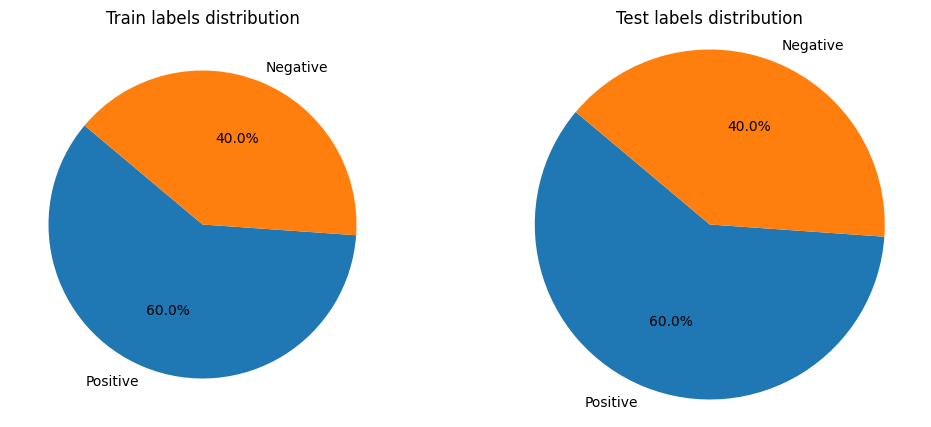

In [ ]:
amazon_train_df, amazon_test_df = loaders.load_raw_data(constants.DatasetAmazon, root_path="/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis")
visualization.plot_label_distribution(amazon_train_df, amazon_test_df)

In [ ]:
amazon_train_df[constants.ColumnLabel].replace({1: 0, 2: 1}, inplace=True)
amazon_test_df[constants.ColumnLabel].replace({1: 0, 2: 1}, inplace=True)
amazonTrainDataset, amazonTestDataset = datasets.Dataset.from_pandas(amazon_train_df.dropna()).rename_column("Text", "text").rename_column("Label", "labels"), datasets.Dataset.from_pandas(amazon_test_df.dropna()).rename_column("Text", "text").rename_column("Label", "labels")

## Model Initialization

In [ ]:
pretrained_llm_model = "distilbert/distilbert-base-uncased"
model_name = "DistilBert_FineTunedClassifier"
model_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Models/DistilBert_Big_Amazon"

In [ ]:
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:


tokenizer = AutoTokenizer.from_pretrained(pretrained_llm_model, use_fast=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(pretrained_llm_model, num_labels=num_labels)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset, test_dataset =  amazonTrainDataset.shard(num_shards=50, index=1), amazonTestDataset.shard(num_shards=50, index=1)
preprocessor = lambda x: tokenizer(text=x["text"], truncation=True, padding=True, max_length=512)
def preprocessor(x):
  if not x['text']:
    print(x['text'])
  return tokenizer(x['text'], truncation=True, padding=True, max_length=512)
train_dataset = train_dataset.map(preprocessor, batched=False)
test_dataset = test_dataset.map(preprocessor, batched=False)

Map:   0%|          | 0/59997 [00:00<?, ? examples/s]

Map:   0%|          | 0/13000 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['labels', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 59997
})

In [ ]:
batch_size = 16
args = TrainingArguments(
    output_dir = model_path,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=4.75233455716045e-05,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(pretrained_llm_model, num_labels=2)

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.320500,0.307264,0.867231
2,0.237200,0.361496,0.870231
3,0.146500,0.497790,0.865538
4,0.081700,0.607115,0.863385
5,0.042000,0.833962,0.864615


TrainOutput(global_step=18750, training_loss=0.17142768290201824, metrics={'train_runtime': 1948.2642, 'train_samples_per_second': 153.976, 'train_steps_per_second': 9.624, 'total_flos': 1.6375361355192108e+16, 'train_loss': 0.17142768290201824, 'epoch': 5.0})

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

[I 2024-04-11 06:07:20,371] A new study created in memory with name: no-name-5dc32476-32b1-47db-a05e-4d801aaaf387
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.312574,0.859692
2,0.352700,0.322054,0.861846


[I 2024-04-11 06:13:55,166] Trial 0 finished with value: 0.8618461538461538 and parameters: {'learning_rate': 3.584779526285929e-05, 'num_train_epochs': 2, 'seed': 28, 'per_device_train_batch_size': 64}. Best is trial 0 with value: 0.8618461538461538.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.we

Epoch,Training Loss,Validation Loss,Accuracy
1,0.376400,0.333310,0.856923
2,0.241600,0.441627,0.860154
3,0.143900,0.652497,0.857077


[I 2024-04-11 06:24:18,508] Trial 1 finished with value: 0.8570769230769231 and parameters: {'learning_rate': 3.820580294145035e-05, 'num_train_epochs': 3, 'seed': 25, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.8618461538461538.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.wei

Epoch,Training Loss,Validation Loss,Accuracy
1,0.491800,0.489113,0.816615


[I 2024-04-11 06:28:33,410] Trial 2 finished with value: 0.8166153846153846 and parameters: {'learning_rate': 9.670449869014413e-05, 'num_train_epochs': 1, 'seed': 29, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 0.8618461538461538.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.wei

Epoch,Training Loss,Validation Loss,Accuracy
1,0.488900,0.495140,0.845077
2,0.454300,0.524463,0.851385
3,0.405500,0.528261,0.853077
4,0.360400,0.531339,0.855231


[I 2024-04-11 06:45:25,012] Trial 3 finished with value: 0.8552307692307692 and parameters: {'learning_rate': 1.3350249504318555e-06, 'num_train_epochs': 4, 'seed': 20, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 0.8618461538461538.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.we

Epoch,Training Loss,Validation Loss,Accuracy
1,0.421800,0.447516,0.863385


[I 2024-04-11 06:49:36,338] Trial 4 finished with value: 0.8633846153846154 and parameters: {'learning_rate': 2.1354610986049886e-05, 'num_train_epochs': 1, 'seed': 36, 'per_device_train_batch_size': 4}. Best is trial 4 with value: 0.8633846153846154.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.we

Epoch,Training Loss,Validation Loss,Accuracy
1,0.325600,0.319298,0.866154


[I 2024-04-11 06:52:53,961] Trial 5 finished with value: 0.8661538461538462 and parameters: {'learning_rate': 4.75233455716045e-05, 'num_train_epochs': 1, 'seed': 26, 'per_device_train_batch_size': 16}. Best is trial 5 with value: 0.8661538461538462.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.wei

Epoch,Training Loss,Validation Loss,Accuracy
1,0.354600,0.371244,0.847231


[I 2024-04-11 06:56:20,499] Trial 6 pruned. 
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.441800,0.446805,0.855077
2,0.392400,0.581235,0.861077
3,0.246000,0.680460,0.861077


[I 2024-04-11 07:08:57,019] Trial 7 finished with value: 0.8610769230769231 and parameters: {'learning_rate': 1.435451781123888e-05, 'num_train_epochs': 3, 'seed': 4, 'per_device_train_batch_size': 4}. Best is trial 5 with value: 0.8661538461538462.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weig

Epoch,Training Loss,Validation Loss,Accuracy
1,0.404600,0.334022,0.852769


[I 2024-04-11 07:12:08,071] Trial 8 pruned. 
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.516900,0.522887,0.824923


[I 2024-04-11 07:16:21,376] Trial 9 pruned. 


In [ ]:
best_run

BestRun(run_id='5', objective=0.8661538461538462, hyperparameters={'learning_rate': 4.75233455716045e-05, 'num_train_epochs': 1, 'seed': 26, 'per_device_train_batch_size': 16}, run_summary=None)

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
!export CUDA_LAUNCH_BLOCKING=1

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.325600,0.319298,0.866154


TrainOutput(global_step=1875, training_loss=0.35065194905598956, metrics={'train_runtime': 195.9739, 'train_samples_per_second': 153.077, 'train_steps_per_second': 9.568, 'total_flos': 1639645497735036.0, 'train_loss': 0.35065194905598956, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.36149588227272034,
 'eval_accuracy': 0.8702307692307693,
 'eval_runtime': 26.0621,
 'eval_samples_per_second': 498.808,
 'eval_steps_per_second': 31.195,
 'epoch': 5.0}

In [ ]:
trainer.save_model(output_dir=model_path)

In [ ]:
from transformers import pipeline

In [ ]:
c = pipeline("text-classification", model="/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Models/DistilBert_Amazon", device=0, tokenizer=tokenizer)

In [ ]:
c("This is a very terrible product but I like it, I don't know why,")

[{'label': 'LABEL_1', 'score': 0.9894815683364868}]